In [1]:
!pip install numpy
!pip install meshpy
!pip install cmake
!pip install f90wrap
!git clone https://gitlab.com/enrico_facca/dmk_solver.git
!git clone https://gitlab.com/enrico_facca/globals.git
!git clone https://gitlab.com/enrico_facca/linear_algebra.git 
!git clone https://gitlab.com/enrico_facca/geometry.git 
!git clone https://gitlab.com/enrico_facca/p1galerkin.git 
!mkdir dmk_solver/build
!cd dmk_solver/build && cmake ..
!cd dmk_solver/build && make
!cd dmk_solver/build && pwd && make f2py_interface_dmk

     |████████████████████████████████| 481kB 13.6MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for meshpy: filename=MeshPy-2020.1-cp37-cp37m-linux_x86_64.whl size=426429 sha256=18328592213c00a3fa37ec28e56621601581e4cdfb2f9368b55ef4054ade7c00
  Stored in directory: /root/.cache/pip/wheels/01/5d/ed/bbe62e2a24d8c2302b4daf59e97b80a12d797f323d23a1b24e
  Created wheel for pytools: filename=pytools-2021.2.3-py2.py3-none-any.whl size=60512 sha256=f018c6498cef87ef1b8afa1dda92a4d6654025e2774e46635e46acc47c5c0797
  Stored in directory: /root/.cache/pip/wheels/d0/c9/8a/fae4cdf6d718d3d63a5a24ed2b49cfd4668257e4a05ff50ced
  Created wheel for gmsh-interop: filename=gmsh_interop-2021.1-py2.py3-none-any.whl size=21616 sha256=67bf525b885990438b742b5d46377cabc3754ee3d29495bea563cadbd477d80d
  Stored in directory: /root/.cache/pip/wheels/e6/7e/e2/fac903611abad5ae3472b8bcd35a8a55e3b313bd5aa2472c83
Successfully built meshpy pytools gmsh-interop
     |███████████████████████████

In [1]:
# 
# Loading stardard and dmk pyhton modules
#

# Standard tools
import sys
import numpy as np


# Import I/O for timedata
root = '/home/dtheuerkauf/Nextrout/dmk_utilities/'
try:
    sys.path.append(root+'/globals/python/timedata/')
    import timedata as td
except:
    print("Global repo non found")

# Import geometry tools
sys.path.append(root+'/geometry/python/')
import meshtools as mt
sys.path.append(root+'/dmk_solver/otp_solver/preprocess/assembly/')
import example_grid

# Import dmk tools
sys.path.append(root+'/dmk_solver/otp_solver/python')
import dmk_p1p0 
sys.path.append(root+'/dmk_solver/build/python/fortran_python_interface/')
from dmk import (Dmkcontrols,    # controls for dmk simulations)
                 Timefunctionals, # information of time/algorithm evolution
                Dmkinputsdata, # structure variable containg inputs data
                 build_subgrid_rhs, #procedure to preprocess forcing term f
                 Tdenspotentialsystem, # input/output result tdens, pot
                dmkp1p0_steady_data   # main interface subroutine
                )
# Import plot tools
import matplotlib.pyplot as plt

/home/dtheuerkauf/Nextrout/dmk_utilities/dmk_solver/globals/python_timedata
/home/dtheuerkauf/Nextrout/dmk_utilities/dmk_solver/otp_solver/python/examples/diego
/home/dtheuerkauf/Nextrout/dmk_utilities/dmk_solver/otp_solver/preprocess/assembly
/home/dtheuerkauf/Nextrout/dmk_utilities/dmk_solver/build/python/fortran_python_interface


# Define mesh for spatial discretization.
Build the "coord" and "topol" numpy arrays describing coordinate and topology of the mesh.


In [2]:
# set mesh size 
ndiv=25
length=1.0/float(ndiv)
nref=1

# set grid example
flag_grid='unitsquare'

# build grid using prebuild examples 
points, vertices, coord,topol,element_attributes = example_grid.example_grid(flag_grid,length)

# initialized fortran variable for the spatial discretization
[grid,subgrid]=dmk_p1p0.init_geometry(topol, coord, 1)
ncell=grid.ncell
ntdens=grid.ncell
npot=subgrid.nnode

1928


148
272
96
(0.1, 0.21)
(0.3, 0.4)
(0.1, 0.7)


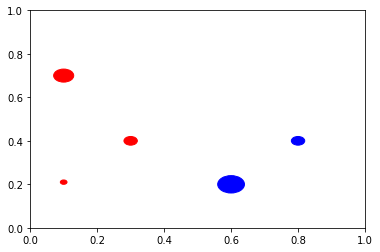

In [6]:
sys.path.append('geometry/python/')
import meshtools as mt
#
# set number, value and location of source and sink points
# 
Nplus=3
Nminus=2

fplus=[1,2,3]
fminus=[4,2]

xplus=[[0.1,0.21],[0.3,0.4],[0.1,0.7]]
xminus=[[0.6,0.2],[0.8,0.4]]

# set array forcing_dirac "evoluation" f=f^{+}-f^{-} on grid nodes
forcing_dirac=np.zeros(grid.nnode)
for i in range(Nplus):
    inode=mt.Inode(coord,xplus[i])
    print(inode)
    forcing_dirac[inode]=fplus[i]
for i in range(Nminus):
    inode=mt.Inode(coord,xminus[i])
    forcing_dirac[inode]=-fminus[i]

# plot location oand intensity of source and sink
ax = plt.gca()
ax.cla() 
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
# some data
for i in range(Nplus):
    print((xplus[i][0],xplus[i][1]))
    circle = plt.Circle((xplus[i][0],xplus[i][1]),0.01*fplus[i], color='red', fill=True)
    ax.add_patch(circle)
for i in range(Nminus):
    circle = plt.Circle((xminus[i][0],xminus[i][1]),0.01*fminus[i], color='blue', fill=True)
    ax.add_patch(circle)
plt.show()

    

# initial integrated forcing term
rhs=np.zeros(subgrid.ncell)
dmk_p1p0.build_subgrid_rhs(subgrid,rhs, np.zeros(ncell),forcing_dirac)


In [4]:
coord

array([[0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 1.        , 0.        ],
       ...,
       [0.72126145, 0.04724419, 0.        ],
       [0.84375   , 0.0174145 , 0.        ],
       [0.15294397, 0.70578287, 0.        ]])

In [5]:
x_source1, y_source1 = (.2,.2)
x_source2, y_source2 = (.2,.7)
wo1 = .05
ho1 = .1
rectangles_source = [[(x_source1,y_source1),wo1,ho1],[(x_source2,y_source2),wo1,ho1]] # bottom left cornner, width, height

x_sink, y_sink = (.8,.8)
wi = .1
hi = .1
rectangles_sink = [[(x_sink,y_sink),wi,hi]] # bottom left cornner, width, height

forcing_rect =np.zeros(grid.nnode)
# iterate over the center of the triangles
for cent in centers.keys():

  x,y = centers[cent]

  for rect in rectangles_source:

    x_source = rect[0][0]
    y_source = rect[0][1]
    wo = rect[1]
    ho = rect[2]

    if (x_source <= x <= x_source+wo) and (y_source <= y <= y_source+ho):
      inode=mt.Inode(coord,centers[cent])
      #print(inode)
      forcing_rect[inode]=1

  for rect in rectangles_sink:

    x_sink = rect[0][0]
    y_sink = rect[0][1]
    wi = rect[1]
    hi = rect[2]

    if (x_sink <= x <= x_sink+wi) and (y_sink <= y <= y_sink+hi):
      inode=mt.Inode(coord,centers[cent])
      #print(inode)
      forcing_rect[inode]=-1



fig, ax = plt.subplots()
len(coord.transpose()[0,:])
ax.tricontour(triang, forcing_rect, levels=40, linewidths=0.1, cmap = 'RdBu_r')
#cntr2 = ax.tricontourf(coord.transpose()[0,:], coord.transpose()[1,:], forcing_dirac, levels=14, cmap="RdBu_r")

plt.subplots_adjust(hspace=0.5)
plt.show()

#print(forcing_dirac);

# initial integrated forcing term
rhs=np.zeros(subgrid.ncell)
dmk_p1p0.build_subgrid_rhs(subgrid,rhs, np.zeros(ncell),forcing_rect)


NameError: name 'centers' is not defined

In [7]:
# define transport post function
def kappa(coord):
    x=coord[0]; y=coord[1]
    fvalue=0.1+np.random.random_sample()
    return fvalue;


# compute functions on cell centroids
ncell=len(topol)
bar_cell=mt.make_bar(coord,topol).transpose()
kappa_cell=np.zeros([ncell]);
for i in range(ncell):
    kappa_cell[i] = kappa(bar_cell[:,i])

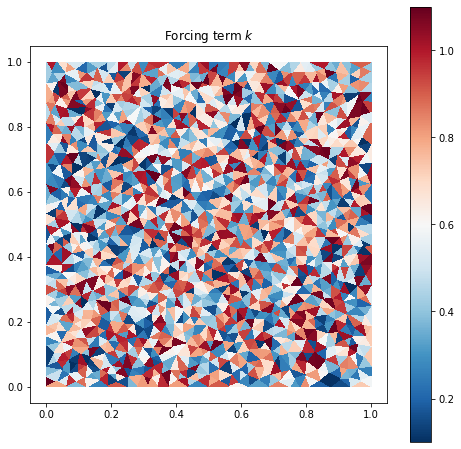

In [8]:
import matplotlib.tri as mtri
#
# plot forcing term
#
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, kappa_cell , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Forcing term $k$')
plt.show()

 We load the controls from file. You can either change it in the file or change some controls in the next cell.

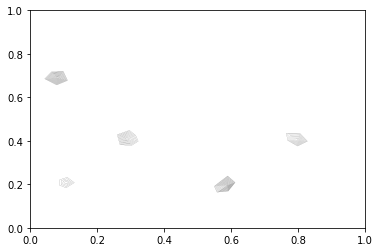

In [9]:
fig, ax = plt.subplots()
len(coord.transpose()[0,:])
len(forcing_dirac)
ax.tricontour(triang, forcing_dirac, levels=40, linewidths=0.1, colors='k')
#cntr2 = ax.tricontourf(coord.transpose()[0,:], coord.transpose()[1,:], forcing_dirac, levels=14, cmap="RdBu_r")

plt.subplots_adjust(hspace=0.5)
plt.show()

#print(forcing_dirac);

In [17]:
# Init and set "container" with inputs for dmk simulation
dmkin=Dmkinputsdata.DmkInputs()
Dmkinputsdata.dmkinputs_constructor(dmkin,0,ntdens,npot,True) # this True set to default all varaibles

# integrate forcing term w.r.t. p1 base function
build_subgrid_rhs(subgrid, dmkin.rhs, np.zeros(grid.ncell),forcing_dirac)
dmkin.pflux = 1.5

# Init "container" variable with tdens(mu) and potential(u) varaible
tdpot=Tdenspotentialsystem.tdpotsys()
Tdenspotentialsystem.tdpotsys_constructor(tdpot,0,ntdens, npot,1)
tdpot.tdens[:]=1.0

# init and set controls
ctrl = Dmkcontrols.DmkCtrl()
Dmkcontrols.get_from_file(ctrl,'./dmk.ctrl')
ctrl.fn_tdens='tdens.dat'
ctrl.fn_pot='pot.dat'
ctrl.fn_statistics='dmk.log'

#
# init type for storing evolution/algorithm info
#
timefun=Timefunctionals.evolfun()
Timefunctionals.evolfun_constructor(timefun, 0,
                                        ctrl.max_time_iterations,
                                        ctrl.max_nonlinear_iterations)

# solve with dmk
info=0
dmkp1p0_steady_data(grid, subgrid, tdpot, dmkin, ctrl, info,timefun=timefun)



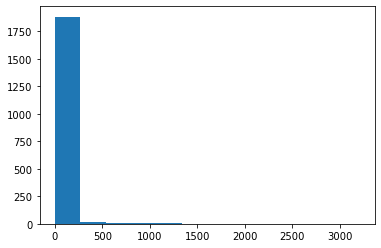

In [18]:

_ = plt.hist(tdpot.tdens, bins='auto') 

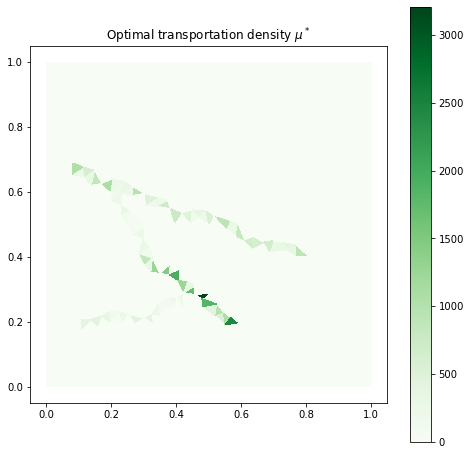

In [19]:
#
# plot forcing term
#
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, tdpot.tdens , cmap='Greens')
fig1.colorbar(tpc)
ax1.set_title('Optimal transportation density $\mu^*$')
plt.show()

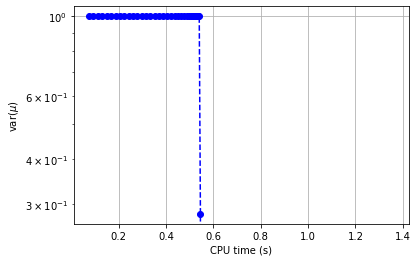

In [13]:
# plot convergence toward steady state
time      = np.array(timefun.time[0:timefun.last_time_iteration]);
cpu_time  = np.array(timefun.cpu_time[0:timefun.last_time_iteration])
var_tdens = np.array(timefun.var_tdens[1:timefun.last_time_iteration])
wass1     = np.array(timefun.lyapunov[1:timefun.last_time_iteration])

plt.figure(1)
plt.yscale('log')
plt.ylabel('var($\mu$)')
plt.xlabel('CPU time (s)')
plt.grid(True)
plt.plot(cpu_time[1:], var_tdens, 'bo--')
plt.show()

# Network pre-extraction

# Building first inputs

G_bar, G_triang, dict_seq

In [ ]:
import networkx as nx
from itertools import combinations
# building G_triang
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)

In [ ]:
coordinates = {}
k=-1
for index_ in coord:
  k+=1
  coordinates [str(k)] = index_[:2]

In [ ]:
G_bar = nx.Graph()
G_triang = nx.Graph()
k=-1
centers= {}
for T in topol: #T is a triangle
  k+=1
  edges_in_T = list(combinations(T, 2))
  for edge in edges_in_T:
    G_triang.add_edge(str(edge[0]),str(edge[1]))
  coord_of_nodes_in_T = np.array([coordinates[str(node)] for node in T])
  #print(len(coord_of_edges_in_T))
  center = sum(coord_of_nodes_in_T)/3
  #print(coord_of_edges_in_T)
  #center = ndimage.measurements.center_of_mass(coord_of_edges_in_T)
  centers[k] = center
  G_bar.add_node(str(k),pos = center, weight = tdpot.tdens[k])

for node in G_triang.nodes():
  G_triang.nodes[node]['pos'] = coordinates[node]

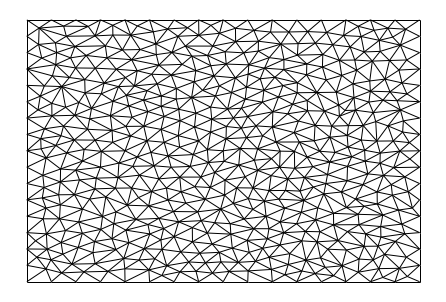

In [ ]:
pos = nx.get_node_attributes(G_triang,'pos')
nx.draw(G_triang,pos, node_size = 0)

1010


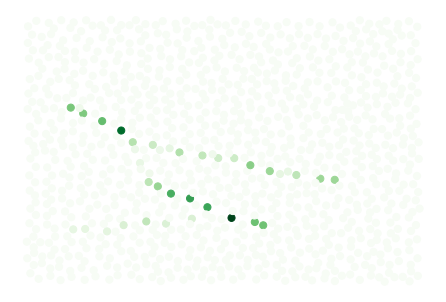

In [ ]:
print(len(G_bar.nodes()))
pos = nx.get_node_attributes(G_bar,'pos')
weights = nx.get_node_attributes(G_bar,'weight')
nx.draw(G_bar,pos, node_size = 50,node_color = list(weights.values()), cmap='Greens')

In [ ]:
def pre_extraction(
		G_bar, G_triang, dict_seq, min_, graph_type='1',weighting_method='ER', t3 = 1
):
	'''
	:param G_bar: a weighted networkX graph whose nodes are the barycenters of the elements of the grid.
	:param G_triang: the grid graph.
	:param dict_seq: dictionary mapping grid elements into their vertices. Namely, dict_seq for the key-th element of the
		grid with vertices are n1,n2 and n3 needs to be defined as dict_seq[key]=[n1,n2,n3].  It works with triangular and squared grids.
	:param graph_type: 1 (to use edges and vertices of the grid), 2 (to use only edges), 3 (to use elements of the grid).
	:param min_: threshold for the weights of the edges after pre-extraction.
	:param max_: maximum weight of nodes in G_bar.
	:param weighting_method: 'ER', 'AVG'.
	:return:
		G_pre_extracted: pre-extracted graph.
	'''


	if graph_type == "3" and weighting_method == "ER":
		print("this wm does not apply for graph type 3. Try with 'AVG'.")
	else:

		if graph_type == "1" or graph_type == "2":
			G_pre_extracted = G_bar.copy()
			# filtering
			edges_ = list(G_pre_extracted.edges())
			G_pre_extracted.remove_edges_from(edges_)
			G_pre_extracted = node_edge_filter(
				G_pre_extracted, min_, graph_type, dict_seq, weighting_method
			)
		elif graph_type == "3":
			# filtering
			# print('here')
			G_pre_extracted = grid_filter(G_bar, G_triang, min_, dict_seq)

		"""
		Removing the non-useful barycenters
		"""

		G_pre_extracted.remove_nodes_from(list(nx.isolates(G_pre_extracted)))

		return G_pre_extracted
def node_edge_filter(G_bar, min_, graph_type, dict_seq, weighting_method,input_flag=None,node2box_index=None, t3 = 1):
	'''
	:param G_bar: a weighted networkX graph whose nodes are the barycenters of the elements of the grid. No edges.
	:param min_:  threshold for the weights of the edges after pre-extraction.
	:param graph_type: 1 (to use edges and vertices of the grid), 2 (to use only edges).
	:param dict_seq:  dictionary mapping grid elements into their vertices. Namely, dict_seq for the key-th element of the
		grid with vertices are n1,n2 and n3 needs to be defined as dict_seq[key]=[n1,n2,n3].  It works with triangular and squared grids.
	:param weighting_method: 'ER', 'AVG'.
	:param input_flag: 'image' or None (for dat files)
	:param node2box_index: given a node, node2box_index[node] returns the indices of all the elements of the partition s.t.,
	node is a vertex of these elements
	:return:
		G_bar: the input graph but with edges generated according to graph_type.
	'''
	"""
	This script generates graph type 1 and 2.
	"""
	nodes_dict = G_bar.nodes(data='weight')
	max_ = max([entry[1] for entry in nodes_dict])

	reduced_node_list = [int(node) for node in G_bar.nodes() if G_bar.nodes[node]['weight']>min_ * max_]

	print('Barycenters whose weight is over the threshold:',len(reduced_node_list))
	# Iterate over all the numbers (<--> nodes) to test the condition about the threshold:
	for n in reduced_node_list:#range(len(G_bar.nodes()))
		#connecting_edges(
		#	G_bar, n + 1, min_, graph_type, dict_seq, max_, weighting_method,input_flag,node2box_index
		#)
		connecting_edges(
			G_bar, n, min_, graph_type, dict_seq, max_, weighting_method,input_flag,node2box_index
		)
	if weighting_method == "ER":

		# Compute degree centrality

		deg = nx.degree_centrality(G_bar)
		N = len(G_bar.nodes())

		# If True, then apply 'ER' method

		for edge in G_bar.edges():
			G_bar.edges[(edge[0], edge[1])]["weight"] = G_bar.nodes[edge[0]]["weight"] / (
					deg[edge[0]] * (N - 1)
			) + G_bar.nodes[edge[1]]["weight"] / (deg[edge[1]] * (N - 1))
	elif weighting_method == "AVG":
		pass
	else:
		print("weighting_method not defined")

	return G_bar

def connecting_edges(G_bar, node, min_, graph_type, dict_seq, max_, weighting_method, input_flag=None,node2box_index=None):
	'''
	Testing the condition of the tdens for a single barycenter . If condition is satisfied, add the edge with weight
	equal to the min. In-place modification of G_bar.
	:param G_bar: a weighted networkX graph whose nodes are the barycenters of the elements of the grid. No edges.
	:param node: target node.
	:param min_: threshold for the weights of the edges after pre-extraction.
	:param graph_type: 1 (to use edges and vertices of the grid), 2 (to use only edges), 3 (to use elements of the grid).
	:param dict_seq: dictionary mapping grid elements into their vertices. Namely, dict_seq for the key-th element of the
		grid with vertices are n1,n2 and n3 needs to be defined as dict_seq[key]=[n1,n2,n3].  It works with triangular and squared grids.
	:param max_: maximum weight of nodes in G_bar.
	:param weighting_method: 'ER', 'AVG'.
	:param input_flag: 'image' or None (for dat files)
	:param node2box_index:  given a node, node2box_index[node] returns the indices of all the elements of the partition s.t.,
	node is a vertex of these elements
	:return:
	'''
	if graph_type == "1":
		# If True, then just the 'first neighbors' are taken.
		if input_flag != 'image':
			node = str(node)
			dict_sec_neig, index_ = get_sec_neig(node, dict_seq)
			index_ = index_[node]
		else:
			node=node-1
			dict_sec_neig, index_ = get_sec_neig_square(node, dict_seq, node2box_index)

	elif graph_type == "2":
		# If True, then just the 'second neighbors' are taken (firsts included).
		if input_flag != 'image':
			node = str(node)
			dict_sec_neig, index_ = get_sec_neig_edges(node, dict_seq)
			index_ = index_[node]
		else:
			node = node - 1
			dict_sec_neig, index_ = get_sec_neig_edges_square(node, dict_seq, node2box_index)


	#print(index_)
	for bar_ in index_:
		if graph_type == "1" or graph_type == "2":  # both edges and vertices
			# Checking if the weights are greater than the threshold x max
			if (
					G_bar.nodes[bar_]["weight"] > min_ * max_
					and G_bar.nodes[node]["weight"] > min_ * max_
			):
				if weighting_method == "AVG":
					# If True, then we assign weights to the edges based on the 'AVG' method
					w_list = [G_bar.nodes[bar_]["weight"], G_bar.nodes[node]["weight"]]
					w = sum(w_list) / len(w_list)  # <--- the average
					# w=w0 #<--- this is the minimum
					G_bar.add_edge(node, bar_, weight=w)
				elif weighting_method == "ER":
					# If True, then we just add the edge. Later on we define the weight.
					G_bar.add_edge(node, bar_)
     
def get_sec_neig(node, dict_seq):
	'''
	This returns all the triangles that share either a vertex or an edge with the triangle in which the 'node'
	is the barycenter.
	:param node: target node.
	:param dict_seq: dictionary mapping grid elements into their vertices. Namely, dict_seq for the key-th element of the
		grid with vertices are n1,n2 and n3 needs to be defined as dict_seq[key]=[n1,n2,n3].  It works with triangular
		and squared grids.
	:return:
		dict_sec_neig: dictionary, s.t., dict_sec_neig[node]= indexes of all the surrounding triangles of 'node'.
		index_: **check this output. it seems to be removable.**
	'''
	same_triang = get_first_neig(
		node, dict_seq
	)  # getting the nodes of the triang that has 'node' as barycenter
	dict_sec_neig = (
		{}
	)  # dict that contains all the surrounding triangles for the 'node'
	dict_sec_neig[node] = []

	# indexes of all the surrounding triangles. This will be useful to call not only the mentioned triangles but also their bar
	index_ = {}
	index_[node] = []
	for key in dict_seq.keys():
		# if one of the nodes is in the triangle, then ...
		if (
				same_triang[0] in dict_seq[key]
				or same_triang[1] in dict_seq[key]
				or same_triang[2] in dict_seq[key]
		):

			# (to avoid repeating the triangles)
			repeated_tr = list(np.array(same_triang) == np.array(dict_seq[key]))

			if repeated_tr != [True, True, True]:
				# ... we define the triangle indexes for a particular node
				dict_sec_neig[node].append(dict_seq[key])
				index_[node].append(key)
	return dict_sec_neig, index_

def get_first_neig(node, dict_seq):
	'''
	This returns the vertices that belong to the triangle for which 'node' is the barycenter
	:param node: node in G_bar.
	:param dict_seq:  dictionary mapping grid elements into their vertices. Namely, dict_seq for the key-th element of the
		grid with vertices are n1,n2 and n3 needs to be defined as dict_seq[key]=[n1,n2,n3].  It works with triangular and squared grids.
	:return:
		same_triang: all the nodes in the triangle (or element of the grid) s.t., node is its barycenter.
	'''
	same_triang = list(dict_seq[node])
	return same_triang


In [ ]:
dict_seq = {}
for key in G_bar.nodes():
  dict_seq[key] = topol[int(key)]

In [ ]:
Gpe = pre_extraction(G_bar,G_triang,dict_seq, .01) 
Gpe.remove_nodes_from(list(nx.isolates(Gpe)))

Barycenters whose weight is over the threshold: 49


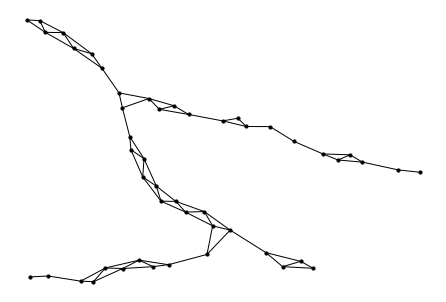

In [ ]:
pos = nx.get_node_attributes(Gpe,'pos')
nx.draw(Gpe,pos, node_size = 10, node_color = 'k')

In [ ]:
sources = []
for i in range(Nplus):
    inode=mt.Inode(coord,xplus[i])
    sources.append(inode)


In [ ]:
sinks = []
for i in range(Nminus):
    inode=mt.Inode(coord,xminus[i])
    sinks.append(inode)

In [ ]:
leaves = [node for node in Gpe.nodes() if Gpe.degree(node)==1]
node_colors = []
for node in Gpe.nodes():
  if node in leaves[:1]:
    node_colors.append('g')
  elif node in leaves[1:]:
    node_colors.append('r')
  else:
    node_colors.append('k')

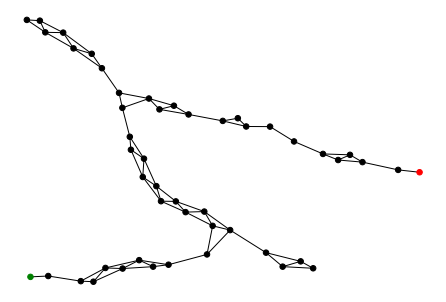

In [ ]:
pos = nx.get_node_attributes(Gpe,'pos')
nx.draw(Gpe,pos, node_size = 30, node_color = node_colors)

# Network filtering

In [ ]:
sys.path.append('dmk_solver/graph_otp_solver/python')
import dmk_graph 

In [ ]:
mapping = {}
k=-1
for node in Gpe.nodes():
  k+=1
  mapping[node] = k
Gpe_rel  =nx.relabel_nodes(Gpe, mapping, copy=True)

In [ ]:
edges = Gpe_rel.edges()
nedges = len(edges)
nodes = Gpe_rel.nodes()
nnodes = len(nodes)
leaves = [node for node in Gpe_rel.nodes() if Gpe_rel.degree(node)==1]

# topol

topol =np.zeros((nedges,2))
k=-1
for edge in edges:
  k+=1
  topol[k,:] = edge
print('topol',topol[:5])  

# weight (uniform)

weight =np.empty(nedges, dtype=object)
k=-1
for edge in edges:
  k+=1
  weight[k] = 1
print('weight',weight[:5])

# rhs (f+ and f-)
import random
rhs = np.zeros(nnodes)
sources = leaves[:1]
number_sources = len(sources)
number_sinks = len(leaves)-len(sources)
for node in nodes:
  if node in leaves:
    if node in sources:
      rhs[node] = 1/number_sources
    else:
      rhs[node] = -1/number_sinks
  else:
    rhs[node] = 0
print('balanced?',sum(rhs))

topol [[ 0. 10.]
 [ 0. 41.]
 [ 1.  2.]
 [ 1. 13.]
 [ 1. 25.]]
weight [1 1 1 1 1]
balanced? 0.0


In [ ]:
rhs

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
# init and set controls
ctrl = Dmkcontrols.DmkCtrl()
Dmkcontrols.get_from_file(ctrl,'dmk_solver/graph_otp_solver/python/examples/FaccaBenzi2021_TestCase1/dmk.ctrl')
# if and where save data
ctrl.id_save_dat=1
ctrl.fn_tdens='tdens.dat'
ctrl.fn_pot='pot.dat'
# if and where save log
ctrl.id_save_statistics=1
ctrl.fn_statistics='dmk.log'
# if print info 
# 
print(ctrl.outer_solver_approach)

b'ITERATIVE           '


In [ ]:
[info,tdens,pot,flux,timefun] = dmk_graph.dmk_graph(topol,rhs,1.0,1e-6,weight,ctrl)
if (info==0):
    print('Convergence achieved')

Convergence achieved


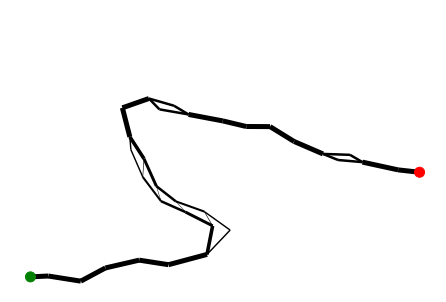

In [ ]:
colors = []
for node in nodes:
  if rhs[node]>0:
    colors.append('g')
  elif rhs[node]<0:
    colors.append('r')
  else:
    colors.append('k')
pos = nx.get_node_attributes(Gpe_rel,'pos')
nx.draw(Gpe_rel, pos,width = 5*flux, node_size = 100*np.abs(rhs), node_color = colors)